## Setup

In [68]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "agent-storming"

In [75]:
# Reading the entire contents of a text file
def read_file_contents(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            return content
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to read the file '{filename}'.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


filename = "../prompts/web_search_instructions.txt"

search_instructions = read_file_contents(filename)
if search_instructions is not None:
    print("Done reading file", filename)

filename = "../prompts/generate_opinion_instructions.txt"

opinion_instructions = read_file_contents(filename)
if opinion_instructions is not None:
    print("Done reading file", filename)

Done reading file ../prompts/web_search_instructions.txt
Done reading file ../prompts/generate_opinion_instructions.txt


In [70]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

## Building the graph

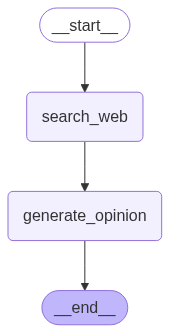

In [71]:
from langgraph.graph import MessagesState
from typing import  Annotated
import operator
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display


tavily_search = TavilySearch(max_results=5, topic="general", include_raw_content=False)


class Persona(BaseModel):
    name: str = Field(
        description="Name of the persona."
    )
    role: str = Field(
        description="Role of the persona in the context of the topic.",
    )
    description: str = Field(
        description="Description of the persona focus, concerns, and expertise.",
    )
    @property
    def to_string(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nDescription: {self.description}\n"


class PersonaState(MessagesState):
    context: str # Source docs
    persona: Persona # Expert persona asking questions
    topic: str # Topic of discussion


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.", max_length=300)


def search_web(state: PersonaState):
    
    """ Retrieve docs from web search """

    persona = state["persona"]
    messages = state["messages"]
    topic = state["topic"]
    
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    system_message = search_instructions.format(topic=topic, persona=persona.to_string)
    search_query = structured_llm.invoke([SystemMessage(content=system_message)]+messages)
    
    # Search
    search_docs = tavily_search.invoke({"query": search_query.search_query})
              
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": formatted_search_docs} 


def generate_opinion(state: PersonaState):
    
    """ Node to answer a question """

    # Get state
    persona = state["persona"]
    messages = state["messages"]
    context = state["context"]
    topic = state["topic"]

    # Generate an opinion
    system_message = opinion_instructions.format(topic=topic, persona=persona.to_string, context=context)
    opinion = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    # Append it to state
    return {"messages": [opinion]}


# Add nodes and edges 
persona_builder = StateGraph(PersonaState)
persona_builder.add_node("search_web", search_web)
persona_builder.add_node("generate_opinion", generate_opinion)

persona_builder.add_edge(START, "search_web")
persona_builder.add_edge("search_web", "generate_opinion")
persona_builder.add_edge("generate_opinion", END)

# Interview 
memory = MemorySaver()
persona_graph = persona_builder.compile(checkpointer=memory).with_config(run_name="Expert Persona")

# View
display(Image(persona_graph.get_graph().draw_mermaid_png()))


## Testing the graph

In [80]:
topic = "Discussing the architecture and system design for building a real-time object detection system to be deployed on a Raspberry Pi 5"
persona = Persona(name="Maya Rao", role="Edge ML Architect",
description="Focuses on selecting and designing neural architectures and compression strategies that meet edge constraints. Expertise in efficient model families (MobileNet, EfficientNet-lite, YOLO-tiny), Neural Architecture Search, quantization-aware training, pruning, knowledge distillation, and mixed-precision techniques. Primary concerns are accuracy vs. latency/memory trade-offs, maintaining robustness after compression, and integration with edge runtimes (TensorFlow Lite, ONNX Runtime, TVM). She evaluates performance using realistic benchmarks (FPS, p50/p95 latency, peak memory, energy per inference) and guides model-to-runtime translation."
)
first_message = "What do you think?"
thread = {"configurable": {"thread_id": "52"}}

In [81]:
results = persona_graph.invoke({"topic": topic, "persona": persona, "messages": first_message}, thread)
for message in results["messages"]:
    message.pretty_print()

================================ Human Message =================================

What do you think?
================================== Ai Message ==================================

Maya Rao, Edge ML Architect

My recommendation is to treat this as a 3-phase engineering problem: (1) pick/fit an efficient architecture and target accuracy, (2) aggressively compress and profile on-device, (3) build a low-latency capture–inference pipeline and validate with real benchmarks. For the Pi 5, start with small-but-capable families: MobileNetV2/SSD‑Lite or EfficientDet‑Lite for strict memory/latency budgets, and YOLO‑tiny / YOLO‑NAS‑nano if you need better box quality. Use 320–416px inputs as your baseline and iterate upward only if accuracy demands it.

Compression and runtime: prefer quantization-aware training (QAT) to avoid accuracy collapse, and combine pruning + knowledge distillation (teacher -> tiny student) when you need extra throughput. Export to TFLite with XNNPACK and NEON optimizat

In [82]:
results = persona_graph.invoke({"messages": "target FPS/latency is 25 frames per second, acceptable mAP is 75%"}, thread)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Maya Rao, Edge ML Architect

25 FPS (40 ms/frame) with a 75% mAP is a tight but achievable goal depending on what you mean by “mAP” (mAP@0.5 vs mAP@[.5:.95]) and dataset complexity (number of classes, small objects, occlusion). Clarify that first. If you mean ~75% mAP@0.5 on a curated/custom dataset with moderate object sizes and <20 classes, you can target this on Pi 5 with a carefully chosen model + compression pipeline; if you mean COCO-style mAP@[.5:.95], that target will be unrealistic on the Pi without an external accelerator.

Concrete plan and latency budget:
- Budget per frame ~40 ms end-to-end: capture + preproc 5–10 ms (CSI camera + zero-copy), model inference 20–25 ms, postproc (NMS, drawing) 5–10 ms. Use producer/consumer threads + frame queue to hide capture latency and keep steady 25 FPS.
- Model candidates to iterate: EfficientDet‑Lite1 (or Lite0 if you need lower latency), MobileNetV3-SSD

In [83]:
print(persona_graph.get_state(thread).values.get('context'))

<Document href="https://medium.com/accelr-blog/raspberry-pi-object-detection-benchmarks-cc193f287926"/>
Missing: 75% candidates optimization EfficientDet‑ YOLO‑ NAS‑ nano), INT8, pruning+ distillation, XNNPACK/ ONNX/
</Document>

---

<Document href="https://github.com/kiena-dev/YOLOv5-tensorflow-lite-Raspberry-Pi"/>
Missing: 25 75% candidates recipes (MobileNetV2 SSD‑ EfficientDet‑ NAS‑ nano), QAT pruning+ distillation, XNNPACK/ ONNX/ TVM
</Document>

---

<Document href="https://pyimagesearch.com/2020/01/27/yolo-and-tiny-yolo-object-detection-on-the-raspberry-pi-and-movidius-ncs/"/>
Missing: 25 75% candidates Lite, EfficientDet‑ NAS‑ INT8, pruning+ distillation, TFLite XNNPACK/ ONNX/ TVM
</Document>

---

<Document href="https://www.youtube.com/watch?v=_WKS4E9SmkA"/>
Missing: 75% mAP: candidates optimization (MobileNetV2 SSD‑ Lite, EfficientDet‑ tiny/ NAS‑ INT8, pruning+ distillation, TFLite XNNPACK/ ONNX/ TVM
</Document>

---

<Document href="https://www.researchgate.net/publication